In [8]:
import sys
sys.path.insert(1, '../../decode_eeg/')
import decode_eeg
import numpy as np
np.random.seed(42)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
experiment_name1 = '1801'
experiment_name2 = '1901'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'

exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)

# Color to Orientation

In [10]:
time_window = 25
time_step = 25
trial_average = 20
n_splits = 500
group_dict = {0:[1],1:[2],2:[3],3:[4]}
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1])

clfr = decode_eeg.Classification(wrangl,sync.nsub,num_labels=4)

In [11]:
for isub,sub in enumerate(sync.matched_ids):
    xdata,ydata = sync.load_eeg(sub)
    xdata,ydata = sync.setup_data(xdata,ydata)
    xdata_train,xdata_test,ydata_train,ydata_test = sync.group_data(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_custom_split(xdata_train,xdata_test,ydata_train,ydata_test):
        y_test_shuffle = np.random.permutation(y_test)
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle, isub)

100.0%

In [12]:
interp_color = decode_eeg.Interpreter(clfr,subtitle=f'color_to_ori_trialbin{trial_average}_')
interp_color.save_results()
# interp_color.load_results(filename = 'color_to_ori_trialbin20_20200528_1849.pickle')

Saving output\figures\color_to_ori_trialbin20_acc20200530_0206.pdf
Saving output\figures\color_to_ori_trialbin20_acc20200530_0206.png


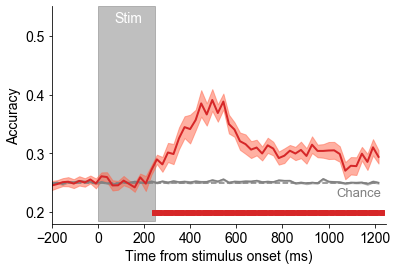

In [17]:
interp_color.plot_acc(significance_testing=True,upper=.55,lower=.185,savefig=True)

# Orientation to Color

In [13]:
sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2],
                                    wrangler = wrangl,
                                    train_group = [experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync.nsub,num_labels=4)

In [14]:
for isub,sub in enumerate(sync.matched_ids):
    xdata,ydata = sync.load_eeg(sub)
    xdata,ydata = sync.setup_data(xdata,ydata)
    xdata_train,xdata_test,ydata_train,ydata_test = sync.group_data(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_custom_split(xdata_train,xdata_test,ydata_train,ydata_test):
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                clfr.decode(X_train,X_test,y_train,y_test,isub)

100.0%

In [15]:
interp = decode_eeg.Interpreter(clfr,subtitle=f'ori_to_color_{trial_average}_')
interp.save_results()
# interp.load_results('ori_to_color_20_20200529_2109.pickle')

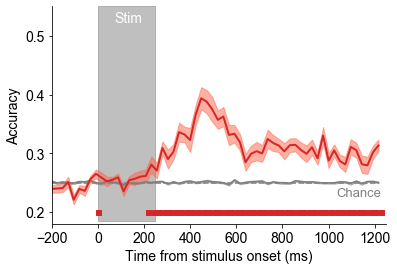

In [91]:
interp.plot_acc(significance_testing=True,savefig=0)

Saving output\figures\ori_to_color_20_acc20200530_0418.pdf
Saving output\figures\ori_to_color_20_acc20200530_0418.png


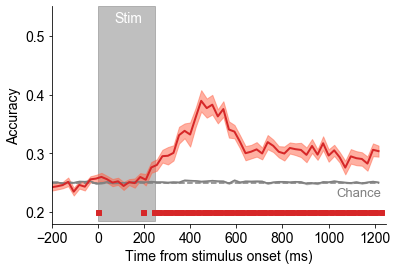

In [92]:
interp.plot_acc_single_feature(interp_color.acc,interp_color.acc_shuff, significance_testing=True,savefig=1)